In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns

In [2]:
df = pd.read_csv('dataset.csv')
df['NewExist'] = df['NewExist'].fillna(0)
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'cat_activites', 'SBA_loan_float', 'bank_loan_float', 'crisis'],
      dtype='object')

In [3]:


features_of_interest = [
    'State','NAICS', 'UrbanRural','LowDoc','bank_loan_float','SBA_loan_float','FranchiseCode','Bank','BankState','RevLineCr','Term','crisis',
    'MIS_Status',
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term'
    
]


ordinal_column = [
    'LowDoc'
]

categorical_column = [
    'State','NAICS','FranchiseCode','Bank','RevLineCr','BankState'
]


target_name = "MIS_Status"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

In [7]:
data.columns

Index(['State', 'NAICS', 'UrbanRural', 'LowDoc', 'bank_loan_float',
       'SBA_loan_float', 'FranchiseCode', 'Bank', 'BankState', 'RevLineCr',
       'Term', 'crisis', 'MIS_Status'],
      dtype='object')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('MIS_Status', axis=1)
X_test = X_test.drop('MIS_Status', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [5]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column),
    ],
    remainder="passthrough",
)

In [6]:

# xgboost = make_pipeline(preprocessor,XGBClassifier(n_estimators= 200,
#             max_depth=15,
#             learning_rate=0.10840014721366319,
#             l2_leaf_reg=1.4776221959026012,
#             subsample=0.7239372137199894,
#             random_state=42,
#             verbose=0,  # Pas de sortie de logs pendant l'entraînement
#             thread_count=8 )) # Limiter l'utilisation à 8 cœurs)) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans
# xgboost.fit(X_train, y_train_encoded)

# xgboost = make_pipeline(preprocessor,XGBClassifier(n_estimators= 119,
#             max_depth=14,
#             learning_rate=0.04814467217650161,
#             l2_leaf_reg=4.016995083898275,
#             subsample=0.878600281645885,
# ))
# xgboost.fit(X_train, y_train_encoded)

xgboost = make_pipeline(preprocessor,XGBClassifier(n_estimators= 191,
            max_depth=14,
            learning_rate=0.12651139781835524,
            subsample= 0.7979755868081188,
))
xgboost.fit(X_train, y_train_encoded)

/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'NAICS',
                                                   'FranchiseCode', 'Bank',
                                                   'RevLineCr', 'BankState']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc']),
                                                 ('numeric', RobustScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('xgbclassifier',
                 XGBCla...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.12651139781835524, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=14,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=191,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [7]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = xgboost.predict_proba(X_test)[:, 1]
y_pred = xgboost.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', xgboost.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

AUC-ROC score: 0.9802923391607222
accuracy 0.9522782121289634
rappel 0.838613610442276
f1_score 0.8605051851370241
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.91      0.92     89917
weighted avg       0.95      0.95      0.95     89917



#### stat meilleur XGBOOST 

AUC-ROC score: 0.9801501116364613
accuracy 0.9520001779418797
rappel 0.8287289316943354
f1_score 0.8583710704206865
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.93      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917

In [164]:
df_rf = pd.DataFrame(xgboost[-1].feature_importances_,xgboost[0].get_feature_names_out())
df_rf=df_rf.transpose()
df_rf.columns

Index(['categorical__State_AK', 'categorical__State_AL',
       'categorical__State_AP', 'categorical__State_AR',
       'categorical__State_AZ', 'categorical__State_CA',
       'categorical__State_CO', 'categorical__State_CT',
       'categorical__State_DC', 'categorical__State_DE',
       ...
       'categorical__BankState_WI', 'categorical__BankState_WV',
       'categorical__BankState_WY', 'categorical__BankState_nan',
       'ordinal__LowDoc', 'numeric__bank_loan_float',
       'numeric__SBA_loan_float', 'numeric__Term', 'remainder__UrbanRural',
       'remainder__crisis'],
      dtype='object', length=9812)

In [165]:
liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in f'_{elem}_':
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')


In [39]:
df_rf.sort_values(by= 0,axis=1, ascending=False)

,sum_State,sum_BankState,sum_FranchiseCode,numeric__Term,sum_Term,sum_cat_activites,sum_RevLineCr,categorical__BankState_VA,categorical__BankState_CA,categorical__FranchiseCode_0,...,categorical__FranchiseCode_31415,categorical__FranchiseCode_32046,categorical__FranchiseCode_32050,categorical__FranchiseCode_32053,categorical__FranchiseCode_32055,categorical__FranchiseCode_32060,categorical__FranchiseCode_32063,categorical__FranchiseCode_32067,categorical__FranchiseCode_32070,sum_MIS_Status
0,0.600629,0.399422,0.118466,0.092381,0.092381,0.077125,0.052881,0.049695,0.038084,0.030347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


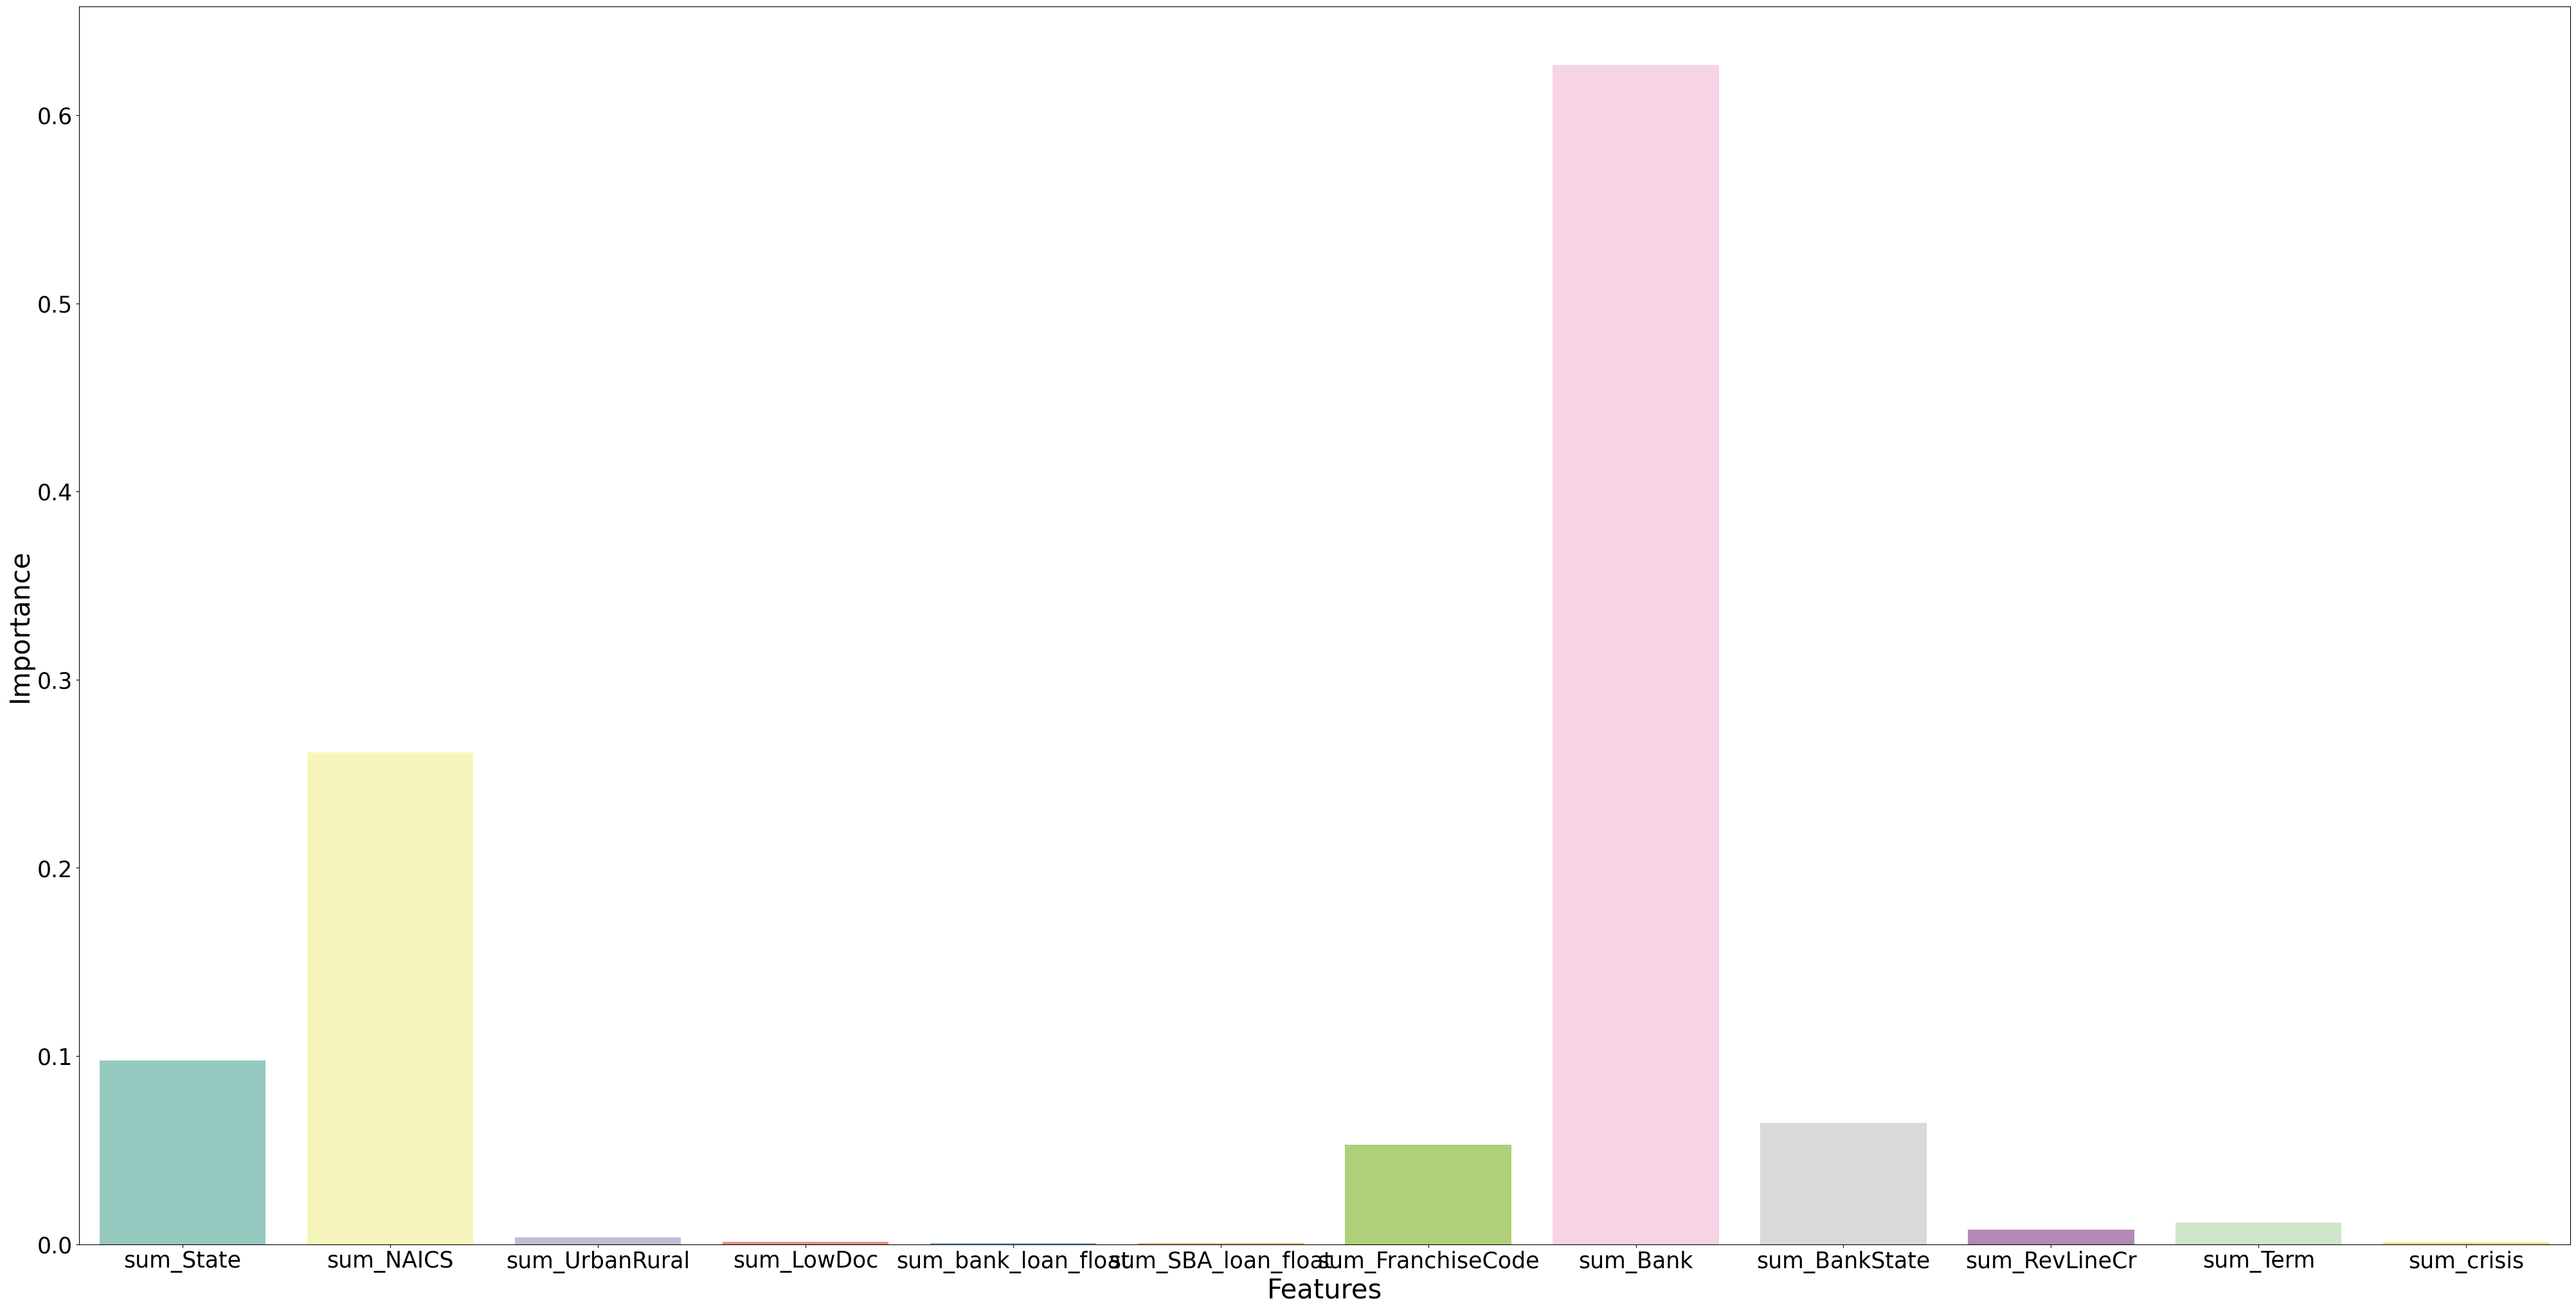

In [166]:


df_rf_graphique = df_rf[liste_sum]


plt.figure(figsize=(50, 25))
sns.barplot(data=df_rf_graphique.drop('sum_MIS_Status', axis = 1), palette="Set3")

# Augmenter la taille des labels des axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Augmenter la taille des ticks des axes
plt.tick_params(axis='both', labelsize=25)
plt.show()

In [41]:
# import pickle
# pickle.dump(xgboost,open('xgboost_lgbm_polyfeatures.pkl','wb'))

In [114]:
import optuna

def objective(trial):
    # Définir les hyperparamètres à optimiser
    # n_estimators = trial.suggest_int('n_estimators', 150, 200)
    # max_depth = trial.suggest_int('max_depth', 6, 16)
    # learning_rate = trial.suggest_float('learning_rate', 0.3, 0.6, log=True)
    # l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 11, 20)
    # subsample = trial.suggest_float('subsample', 0.3, 1)

    n_estimators = trial.suggest_int('n_estimators', 0, 200)
    max_depth = trial.suggest_int('max_depth', 4, 16)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    # Créer le modèle de classification avec les hyperparamètres choisis
    xgboost = make_pipeline(
        preprocessor, 
        XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            subsample=subsample,
            random_state=42,
            verbose=0,  # Pas de sortie de logs pendant l'entraînement
            thread_count=8  # Limiter l'utilisation à 8 cœurs
        )
    ) 
    
    # Entraîner le modèle
    xgboost.fit(X_train, y_train_encoded)
    
    # Prédire sur le jeu de test et calculer l'accuracy
    y_pred = xgboost.predict(X_test)
    proba = xgboost.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test_encoded, proba)
    
    return roc_auc

# Créer et lancer l'étude Optuna
study = optuna.create_study(direction='maximize')  # Maximiser l'accuracy
study.optimize(objective, n_trials=150)  # Essayer 10 différentes combinaisons d'hyperparamètres



# Afficher les meilleurs hyperparamètres et le meilleur score
print('Meilleurs hyperparamètres :', study.best_params)
print('Meilleur score d\'accuracy :', study.best_value)

[I 2025-02-12 12:29:21,857] A new study created in memory with name: no-name-d70b29fe-1136-4c4e-9755-c655bf3435e0
/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:29:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "l2_leaf_reg", "thread_count", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-12 12:29:39,783] Trial 0 finished with value: 0.9760111206802586 and parameters: {'n_estimators': 195, 'max_depth': 8, 'learning_rate': 0.08365262538214988, 'l2_leaf_reg': 8.488795653066095, 'subsample': 0.9470856508409851}. Best is trial 0 with value: 0.9760111206802586.
/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:29:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "l2_leaf_reg", "thread_count", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-12 12:30:04,601] Trial 1 fi

Meilleurs hyperparamètres : {'n_estimators': 191, 'max_depth': 14, 'learning_rate': 0.12651139781835524, 'l2_leaf_reg': 8.539092637997864, 'subsample': 0.7979755868081188}
Meilleur score d'accuracy : 0.9788735177684875


In [53]:
import optuna
from optuna import create_study

# Créer une étude avec une base de données persistante
study = create_study(study_name="example-study", storage="sqlite:///optuna_db.db", direction="maximize")

# Lancer une optimisation
study.optimize(objective, n_trials=5)

# Lancer le tableau de bord Optuna avec la base de données persistante
!optuna-dashboard sqlite:///optuna_db.db



[I 2025-02-11 16:27:59,369] A new study created in RDB with name: example-study
/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "l2_leaf_reg", "thread_count", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-11 16:28:05,081] Trial 0 finished with value: 0.9413694860327907 and parameters: {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.01931886587236998, 'l2_leaf_reg': 5.977418430145165, 'subsample': 0.9332567622643444}. Best is trial 0 with value: 0.9413694860327907.
/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "l2_leaf_reg", "thread_count", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-11 16:28:35,854] Trial 1 finished with value: 0.9766640411363

KeyboardInterrupt: 